In [39]:
num_positives = 8
num_negatives_per_positive = 4

In [5]:
# Load entire corpus
import json
def load_jsonl(path):
    with open(path) as f:
        return [json.loads(i) for i in f.readlines()]
        
corpus = load_jsonl("/gallery_louvre/dayoon.ko/research/sds/src/datasets/trec-covid/corpus.jsonl")
corpus_dict = {}
for item in corpus:
    corpus_dict[item["_id"]] = item["text"]

In [26]:
# Load succ and fail csv files
import pandas as pd
path = "/gallery_louvre/dayoon.ko/research/sds/retrieval/results/multilingual-e5-large/trec-covid-n-query-mt-2.csv"
df = pd.read_csv(path)
df = df.drop('Unnamed: 0', axis=1)
df = df.set_index("corpus-id")
df
# Get succ and fail corpus-id
#meta = df.to_dict()
#print(meta)

,n-query,recall,precision,f1
corpus-id,,,,
n15i01tn,2,0.000000,0.0,0.000000
k9lcpjyo,2,0.500000,1.0,0.666667
jbtrdvhe,6,0.166667,1.0,0.285714
juz9jnfk,5,0.400000,1.0,0.571429
4dtk1kyh,3,0.333333,1.0,0.500000
...,...,...,...,...
yb5kf0u2,3,0.333333,1.0,0.500000
48ay8yl3,4,0.000000,0.0,0.000000
wzv8n34v,3,0.333333,1.0,0.500000


In [30]:
df.loc["n15i01tn"]["n-query"]

2.0

In [58]:
def filter_data(res):
    for i in res:
        i["retrieval"] = [j for j in i["retrieval"] if i["_id"] != j]
    return res

In [74]:
def get_ret_map(pth):
    pth1 = path.replace(".csv", "-d2d-retrieval.jsonl")
    res1 = load_jsonl(pth1)
    res1 = filter_data(res1)
    res1 = {i["_id"]: i["retrieval"] for i in res1}
    pth2 = path.replace(".csv", "-d2d2d-retrieval.jsonl")
    res2 = load_jsonl(pth2)
    res2 = filter_data(res2)
    res2 = {i["_id"]: i["retrieval"][1:] for i in res2}
    results = {}
    for qid, ret_ids in res1.items():
        selected_rets = {}
        for ret_id in ret_ids[:num_positives * 2]:
            ret2_ids = res2[ret_id]
            ret2_ids_selected = [i for i in ret2_ids if i not in ret_ids and i != qid]
            ret2_ids_selected = ret2_ids_selected[:num_negatives_per_positive]
            if len(ret2_ids_selected) < num_negatives_per_positive:
                continue
            selected_rets[ret_id] = ret2_ids_selected
            if len(selected_rets) == num_positives:
                break
        results[qid] = selected_rets
    return results
        
ret_map = get_ret_map(path)

In [75]:
def get_dataset(ret_map):
    dataset = []
    for query_id, rets1 in ret_map.items():
        for pos_id, neg_ids in rets1.items():
            query_meta = df.loc[query_id]
            query = corpus_dict[query_id]
            positive = [corpus_dict[pos_id]]
            negatives = [corpus_dict[idx] for idx in neg_ids]
            dataset.append({
                "_id": query_id,
                "recall": query_meta["recall"],
                "precision": query_meta["precision"],
                "f1": query_meta["f1"],
                "query": query,
                "pos": positive,
                "neg": negatives,
            })
    return dataset 

dataset = get_dataset(ret_map)
            

In [76]:
with open("trec-covid/ood_all.json", "w") as f:
    json.dump(dataset, f, indent=2)

#### Deprecated

In [49]:
def get_dataset(path, ret_map):
    path = path.replace(".csv", "-d2-retrieval.jsonl")
    result = load_jsonl(path)

    dataset = []
    for i in result:
        # Filter top-1 
        if i["_id"] == i["retrieval"]:
            continue
        query_id = i["_id"]
        query_meta = df.loc[query_id]
        query = corpus_dict[i["_id"]]
        positive = [corpus_dict[i["retrieval"]]]
        negatives = [corpus_dict[idx] for idx in i["retrieval2"]
                    if idx][1:num_negatives_per_positive+1]
        dataset.append({
            "_id": query_id,
            "recall": query_meta["recall"],
            "precision": query_meta["precision"],
            "f1": query_meta["f1"],
            "query": query,
            "pos": positive,
            "neg": negatives,
        })
    return dataset
        
dataset = get_dataset(path, ret_map)
print(dataset[0])

FileNotFoundError: [Errno 2] No such file or directory: '/gallery_louvre/dayoon.ko/research/sds/retrieval/results/multilingual-e5-large/trec-covid-n-query-mt-2-d2-retrieval.jsonl'

In [9]:
import random

negs = [i["text"] for i in random.sample(corpus, 20) if len(i["text"]) > 0][:5]

def generate_rand_neg_dataset(docs, positives, negatives):
    dataset = []
    for i in range(len(docs)):
        query = docs[i]
        positives_selected = []
        negatives_selected = []
        for j, doc in enumerate(positives[i]):
            if len(negatives[i][j]) == num_negatives_per_positive:
                positives_selected.append(doc)
                negatives_selected.append(negs)
            if len(positives_selected) == 4:
                break
        for p, ns in zip(positives_selected, negatives_selected):
            dataset.append({
                "query": query,
                "pos": [p],
                "neg": ns
            })
    return dataset

In [10]:
succ_dataset = generate_rand_neg_dataset(succ_docs, succ_positives, succ_negatives)
print(succ_dataset[0])
with open("id_randneg_dataset/trec-covid-succ.json", "w") as f:
    json.dump(succ_dataset, f, indent=2)


fail_dataset = generate_rand_neg_dataset(fail_docs, fail_positives, fail_negatives)
print(fail_dataset[0])
with open("ood_randneg_dataset/trec-covid-fail.json", "w") as f:
    json.dump(fail_dataset, f, indent=2)

{'query': 'SARS-CoV-2 has caused tens of thousands of infections and more than one thousand deaths. There are currently no registered therapies for treating coronavirus infections. Because of time consuming process of new drug development, drug repositioning may be the only solution to the epidemic of sudden infectious diseases. We systematically analyzed all the proteins encoded by SARS-CoV-2 genes, compared them with proteins from other coronaviruses, predicted their structures, and built 19 structures that could be done by homology modeling. By performing target-based virtual ligand screening, a total of 21 targets (including two human targets) were screened against compound libraries including ZINC drug database and our own database of natural products. Structure and screening results of important targets such as 3-chymotrypsin-like protease (3CLpro), Spike, RNA-dependent RNA polymerase (RdRp), and papain like protease (PLpro) were discussed in detail. In addition, a database of 78

In [97]:
succ_negatives = get_negatives(succ_path)
succ_negatives_selected = [succ_negatives[i] for i in succ_ids_selected]

In [98]:
def generate_dataset(docs, positives, negatives):
    dataset = []
    for i in range(len(docs)):
        query = docs[i]
        positives_selected = []
        negatives_selected = []
        for j, doc in enumerate(positives[i]):
            if len(negatives[i][j]) == num_negatives_per_positive:
                positives_selected.append(doc)
                negatives_selected.append(negatives[i][j])
            if len(positives_selected) == 4:
                break
        for p, ns in zip(positives_selected, negatives_selected):
            dataset.append({
                "query": query,
                "pos": [p],
                "neg": ns
            })
    return dataset


In [99]:
succ_dataset_selected = generate_dataset(succ_docs_selected, succ_positives_selected, succ_negatives_selected)
print(succ_dataset_selected[0])
with open("trec-covid/ood_well_over_0.4.json", "w") as f:
    json.dump(succ_dataset_selected, f, indent=2)

{'query': 'Importance: The pandemic of coronavirus disease 2019 (COVID-19) caused by the novel severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) presents an unprecedented challenge to identify effective drugs for prevention and treatment. Given the rapid pace of scientific discovery and clinical data generated by the large number of people rapidly infected by SARS-CoV-2, clinicians need accurate evidence regarding effective medical treatments for this infection. Observations: No proven effective therapies for this virus currently exist. The rapidly expanding knowledge regarding SARS-CoV-2 virology provides a significant number of potential drug targets. The most promising therapy is remdesivir. Remdesivir has potent in vitro activity against SARS-CoV-2, but it is not US Food and Drug Administration approved and currently is being tested in ongoing randomized trials. Oseltamivir has not been shown to have efficacy, and corticosteroids are currently not recommended. Current cl

## OOD all consecutive

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


250 250 250


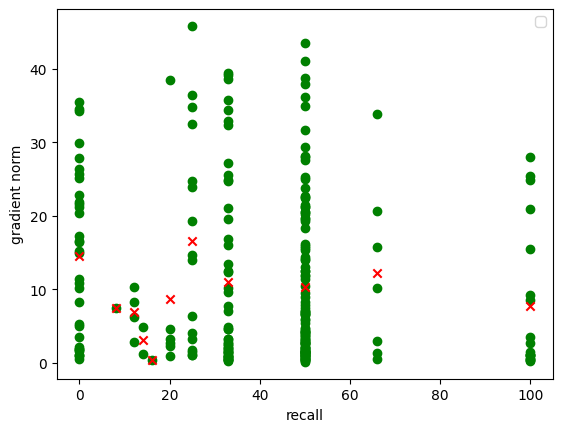

In [18]:
pth = "/gallery_louvre/dayoon.ko/research/sds/FlagEmbedding/FlagEmbedding/BGE_M3/"

def load_file(pth):
    with open(pth) as f:
        lines = f.readlines() 
    return lines 
    
def get_recall_and_score_list(pth):
    lines = load_file(pth)
    gradnorms = []
    for l in lines:
        try: 
            sid = l.index("tensor(") + len("tensor(") 
            eid = sid + 5
            gradnorms.append(float(l[sid:eid]))
        except:
            continue
    recalls = []
    for l in lines:
        try: 
            sid = l.index("recall: ") + len("recall: ") 
            eid = sid + 5
            recalls.append(int(float(l[sid:eid].strip()) * 100))
        except:
            continue
    ids = []
    for l in lines:
        try:
            sid = l.index("doc_id: ") + len("doc_id: ") 
            eid = sid
            ids.append(l[sid:].strip())
        except:
            continue

    gradnorms_selected = []
    recalls_selected = []
    ids_selected = []
    func = min #lambda x: sum(x) / len(x)
    for i in range(0, len(ids), 4):
        gradnorms_selected.append(func(gradnorms[i:i+4]))
        recalls_selected.append(func(recalls[i:i+4]))
        ids_selected.append(ids[i])
            
    return recalls_selected, gradnorms_selected, ids_selected



ood_all = pth + "ood_all"
recalls, gradnorms, ids = get_recall_and_score_list(ood_all)
print(len(recalls), len(gradnorms), len(ids))

import matplotlib.pyplot as plt 
plt.figure()
plt.scatter(recalls, gradnorms, color="green")
plt.xlabel("recall")
plt.ylabel("gradient norm")
#plt.plot(ood_well_o, len(ood_well_o) * [0], "o" , label = "ood-well(tp_over_t>0.4)", color="blue")
#plt.plot(ood_poor, len(ood_poor) * [1], "x" , label = "ood-poor", color="red")

means = {k: [] for k in set(recalls)}
for r, g in zip(recalls, gradnorms):
    means[r].append(g)
means = {k: sum(v) / len(v) for k, v in means.items()}
means = sorted(list(means.items()), key= lambda x: int(x[0]))
xs = [i[0] for i in means]
ys = [i[1] for i in means]
plt.scatter(xs, ys, marker="x", color="red")
plt.legend()
 

In [113]:
data = {
    "_id": ids,
    "recall": recalls,
    "grad_norms": gradnorms,
    "scores": scores
}
import pandas as pd
df = pd.DataFrame(data)
df = df.sort_values("recall")

In [114]:
df.head(20)

,_id,recall,grad_norms,scores
170,qvz63m93,0.0,67.400,"[93.6, 91.5, 92.2, 92.0, 92.1, 92.1]"
162,qvz63m93,0.0,77.260,"[93.8, 92.7, 92.6, 92.3, 92.7, 91.2]"
157,8t35z4gl,0.0,30.120,"[94.1, 90.4, 91.8, 90.5, 90.0, 90.1]"
150,wm6yey1v,0.0,0.365,"[95.2, 87.4, 85.5, 87.5, 87.3, 86.9]"
485,s33brsk6,0.0,0.200,"[98.4, 90.7, 90.2, 89.9, 89.7, 89.5]"
406,sqrn6kjy,0.0,46.190,"[94.3, 90.1, 88.1, 92.0, 91.9, 91.9]"
404,023h20vk,0.0,20.100,"[94.3, 90.3, 90.7, 91.0, 90.9, 90.5]"
402,gdl4l9xo,0.0,84.910,"[92.5, 91.4, 91.2, 90.3, 90.9, 91.2]"
401,dkxi8mgw,0.0,0.188,"[94.6, 85.0, 85.4, 86.6, 86.2, 84.3]"
399,nph01vl6,0.0,21.140,"[94.3, 91.0, 90.5, 91.0, 90.3, 91.1]"


In [115]:
df.tail(20)

,_id,recall,grad_norms,scores
246,itu39mln,1.0,31.990,"[93.1, 88.6, 90.2, 90.0, 90.4, 89.3]"
233,yrrz7oef,1.0,33.450,"[91.9, 89.6, 88.5, 88.9, 87.6, 87.8]"
238,7lk8h93q,1.0,79.550,"[91.8, 89.8, 89.8, 88.8, 89.8, 90.6]"
254,959w9sln,1.0,0.049,"[95.1, 84.6, 84.4, 84.6, 84.8, 85.2]"
550,w94b4aft,1.0,9.019,"[94.4, 88.7, 88.8, 90.2, 89.9, 90.1]"
542,959w9sln,1.0,12.810,"[89.1, 85.0, 84.4, 85.0, 84.4, 84.9]"
492,22vz79nz,1.0,4.726,"[95.1, 89.7, 89.7, 89.9, 90.0, 89.6]"
517,tdvb0fhv,1.0,28.010,"[92.3, 88.6, 89.4, 87.6, 89.1, 88.6]"
496,t3sjv4hv,1.0,2.949,"[95.2, 88.9, 88.9, 90.1, 88.4, 89.6]"
93,tdvb0fhv,1.0,0.115,"[98.1, 88.0, 88.5, 88.7, 88.1, 90.1]"
